In [ ]:
import warnings
warnings.filterwarnings('ignore')

Import libraries

In [ ]:
# Import libraries
import pandas as pd
pd.set_option("display.max_columns", 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import missingno
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# Read data
name = pd.read_excel("/content/short_data.xlsx", sheet_name="Name", index_col=0)     # 8208 cells
public_date = pd.read_excel("/content/short_data.xlsx", sheet_name="Public Date", index_col=0, parse_dates=True)
ocf = pd.read_excel("/content/short_data.xlsx", sheet_name="OCF", index_col=0)   # 1113 missing values   86%
roa = pd.read_excel("/content/short_data.xlsx", sheet_name="ROA", index_col=0)   # 1424    83%
ta = pd.read_excel("/content/short_data.xlsx", sheet_name="TA", index_col=0)   # 1115   86%
mv = pd.read_excel("/content/short_data.xlsx", sheet_name="MV", index_col=0)   # 1795    78%
total_lia = pd.read_excel("/content/short_data.xlsx", sheet_name="Total Lia", index_col=0)    # 1114    86%
sales = pd.read_excel("/content/short_data.xlsx", sheet_name="Sales", index_col=0)   # 1104    87%
tangible_FA = pd.read_excel("/content/short_data.xlsx", sheet_name="Tangible FA", index_col=0)   # 1124    86%
total_ca = pd.read_excel("/content/short_data.xlsx", sheet_name="Total CA", index_col=0)   # 1114    86%
current_lia = pd.read_excel("/content/short_data.xlsx", sheet_name="Total Current Lia", index_col=0)   # 1114    86%
fixed_assets = pd.read_excel("/content/short_data.xlsx", sheet_name="Fixed assets", index_col=0)
accounts_receivable = pd.read_excel("/content/short_data.xlsx", sheet_name="Accounts Receivable", index_col=0)
costs_of_revenue = pd.read_excel("/content/short_data.xlsx", sheet_name="Costs of revenue", index_col=0)
ebit = pd.read_excel("/content/short_data.xlsx", sheet_name="EBIT", index_col=0)
eps = pd.read_excel("/content/short_data.xlsx", sheet_name="EPS", index_col=0)
equity = pd.read_excel("/content/short_data.xlsx", sheet_name="Equity", index_col=0)
avg_receivable_days = pd.read_excel("/content/short_data.xlsx", sheet_name="Avg. Receivable days", index_col=0)
avg_payable_days = pd.read_excel("/content/short_data.xlsx", sheet_name="Avg. Payable days", index_col=0)
avg_inventory_days = pd.read_excel("/content/short_data.xlsx", sheet_name="Avg. Inventory days", index_col=0)

# Biến vĩ mô
gdp = pd.read_excel("/content/short_data.xlsx", sheet_name="GDP", index_col=0)
cpi = pd.read_excel("/content/short_data.xlsx", sheet_name="CPI", index_col=0)
interest_rates = pd.read_excel("/content/short_data.xlsx", sheet_name="Interest rates", index_col=0)

Drop companies are established under 5 years

In [ ]:
# Drop companies are established under 5 years
com_under5years = []
for i in name.index:
  if int(public_date.loc[i,'Date Became Public'].strftime('%Y')) > 2015:
    com_under5years.append(i)
print(len(com_under5years))  # 168 companies are established under 5 years.

name.drop(com_under5years,axis='index', inplace=True)   # 516 remained companies
ocf.drop(com_under5years,axis='columns', inplace=True)
roa.drop(com_under5years,axis='columns', inplace=True)
ta.drop(com_under5years,axis='columns', inplace=True)
mv.drop(com_under5years,axis='columns', inplace=True)
total_lia.drop(com_under5years,axis='columns', inplace=True)
sales.drop(com_under5years,axis='columns', inplace=True)
tangible_FA.drop(com_under5years,axis='columns', inplace=True)
total_ca.drop(com_under5years,axis='columns', inplace=True)
current_lia.drop(com_under5years,axis='columns', inplace=True)
fixed_assets.drop(com_under5years,axis='columns', inplace=True)
accounts_receivable.drop(com_under5years,axis='columns', inplace=True)
costs_of_revenue.drop(com_under5years,axis='columns', inplace=True)
ebit.drop(com_under5years,axis='columns', inplace=True)
eps.drop(com_under5years,axis='columns', inplace=True)
equity.drop(com_under5years,axis='columns', inplace=True)
avg_receivable_days.drop(com_under5years,axis='columns', inplace=True)
avg_payable_days.drop(com_under5years,axis='columns', inplace=True)
avg_inventory_days.drop(com_under5years,axis='columns', inplace=True)
gdp.drop(com_under5years,axis='columns', inplace=True)
cpi.drop(com_under5years,axis='columns', inplace=True)
interest_rates.drop(com_under5years,axis='columns', inplace=True)
public_date = public_date.loc[name.index, :]

public_date.shape # (516, 2) --> 516 remained companies

168


(516, 2)

Biến X: Growth, Size, Age, Liq, Lev, PPE, Quick ratio, Inv turnover ratio, FA turnover ratio, TA turnover ratio, DSO, Capital intensity, Expense revenue ratio, Operating margin, Net profit margin, BEP, ROA, ROE, EPS, CCC.

Biến Y: ni > 0, ocf > 0

Fill Equity, FA, EBIT, cost of revenue, A.R

In [ ]:
# Fill Avg. Inventory days: For the time-series dataset variable, it makes sense to use the interpolation of the variable before and after a timestamp for a missing value.

avg_inventory_days = avg_inventory_days.interpolate(method='linear', limit_direction='both', axis=0)
print(avg_inventory_days.isnull().sum().sum())   # 48 (VNF.HN, VNT.HN, VNL.HM, TVC.HN bị NaN nguyên cột)

# Fill Avg. Payable days

avg_payable_days = avg_payable_days.interpolate(method='linear', limit_direction='both', axis=0)
print(avg_payable_days.isnull().sum().sum())   # 0

# Fill Avg. Receivable days

avg_receivable_days = avg_receivable_days.interpolate(method='linear', limit_direction='both', axis=0)
print(avg_receivable_days.isnull().sum().sum())  # 0

# Fill Equity

equity = equity.interpolate(method='linear', limit_direction='both', axis=0)
print(equity.isnull().sum().sum())

# Fill Fixed Assets

fixed_assets = fixed_assets.interpolate(method='linear', limit_direction='both', axis=0)
print(fixed_assets.isnull().sum().sum())

# Fill EBIT

ebit = ebit.interpolate(method='linear', limit_direction='both', axis=0)
print(ebit.isnull().sum().sum())

# Fill cost of revenue

costs_of_revenue = costs_of_revenue.interpolate(method='linear', limit_direction='both', axis=0)
print(costs_of_revenue.isnull().sum().sum())

# Fill A.R

accounts_receivable = accounts_receivable.interpolate(method='linear', limit_direction='both', axis=0)
print(accounts_receivable.isnull().sum().sum())


48
0
0
0
0
0
0
0


Detect columns having missing values

In [ ]:
def detect_nan(data):
  nan_values = data.isna()
  nan_columns = nan_values.any()
  columns_with_nan = data.columns[nan_columns].tolist()
  return (columns_with_nan)

In [ ]:
detect_nan(avg_inventory_days)

# Because these 4 columns will assurantly be dropped in the next step, we do not fill avg_inventory_days.

['VNF.HN', 'TVC.HN', 'VNT.HN', 'VNL.HM']

Convert negative values to positive values in column Cost of revenue, A.R, Avg.Inv days, Avg. Receivable days, Avg. Payable days.



In [ ]:
# Function converts negative values to positive

def fix_negative(data):
  for j in range(data.shape[1]):
    for i in range(data.shape[0]):
      if data.iloc[i,j] < 0:
        data.iloc[i,j] = 0-data.iloc[i,j]
fix_negative(costs_of_revenue)
fix_negative(accounts_receivable)
fix_negative(avg_inventory_days)
fix_negative(avg_receivable_days)
fix_negative(avg_payable_days)

Calculate variables

In [ ]:
# Calculate NI
ni = roa * ta

# Calculate Size
size = np.log(mv)

# Calculate Leverage
lev = total_lia / ta

# Calculate PPE
ppe = tangible_FA / sales

# Calculate Liquidity
liq = total_ca / current_lia

# Calculate Growth                                            (based on 2010-2020)
growth = sales.pct_change(periods=1)
growth.drop(growth.index[0], axis='index', inplace=True)

# Calculate Inv turnover ratio
inv_turnover = 365 / avg_inventory_days

# Calculate Inv
inv = sales/inv_turnover

# Calculate Quick ratio
quick = (total_ca - inv) / current_lia

# Calculate FA turnover ratio
fa_turnover = sales / fixed_assets

# Calculate TA turnover ratio
ta_turnover = sales / ta

# Calculate DSO
dso = accounts_receivable / (sales / 365)

# Calculate Capital intensity
capital_intensity = ta / sales

# Calculate Expense revenue ratio
expense_revenue = costs_of_revenue / sales

# Calculate Operating margin
operating_margin = ebit / sales

# Calculate Net profit margin
net_profit_margin = ni / sales

# Calculate BEP
bep = ebit / ta

# Calculate ROE
roe = ni / equity

# Calculate growth of CCC
ccc = avg_inventory_days + avg_receivable_days - avg_payable_days


Drop year 2009

In [ ]:
# Drop year 2009
ni.drop(ni.index[0], axis='index', inplace=True)
ocf.drop(ocf.index[0], axis='index', inplace=True)
size.drop(size.index[0], axis='index', inplace=True)
lev.drop(lev.index[0], axis='index', inplace=True)
ppe.drop(ppe.index[0], axis='index', inplace=True)
liq.drop(liq.index[0], axis='index', inplace=True)
inv_turnover.drop(inv_turnover.index[0], axis='index', inplace=True)
quick.drop(quick.index[0], axis='index', inplace=True)
fa_turnover.drop(fa_turnover.index[0], axis='index', inplace=True)
ta_turnover.drop(ta_turnover.index[0], axis='index', inplace=True)
dso.drop(dso.index[0], axis='index', inplace=True)
capital_intensity.drop(capital_intensity.index[0], axis='index', inplace=True)
expense_revenue.drop(expense_revenue.index[0], axis='index', inplace=True)
operating_margin.drop(operating_margin.index[0], axis='index', inplace=True)
net_profit_margin.drop(net_profit_margin.index[0], axis='index', inplace=True)
bep.drop(bep.index[0], axis='index', inplace=True)
roe.drop(roe.index[0], axis='index', inplace=True)
roa.drop(roa.index[0], axis='index', inplace=True)
eps.drop(eps.index[0], axis='index', inplace=True)
ccc.drop(ccc.index[0], axis='index', inplace=True)
gdp.drop(gdp.index[0], axis='index', inplace=True)
cpi.drop(cpi.index[0], axis='index', inplace=True)
interest_rates.drop(interest_rates.index[0], axis='index', inplace=True)

Calculate 'Age' variable

In [ ]:
# Calculate Age of companies
ind = list(range(2010, 2021))
col = size.columns
age = pd.DataFrame(columns=size.columns)

for i in ind:
  list_year = []
  for j in size.columns:
    num = i - public_date.loc[j,'Organization Founded Year']
    list_year.append(num)
  age_length = len(age)
  age.loc[age_length] = list_year
age.index = size.index

# Các công ty thành lập sau năm 2010 được thay thế age bằng np.nan nếu age bị âm.
age = age.replace(list(range(-5,0)), np.NaN)

Query Current asset values are less than Inventory values and sum.

In [ ]:
cols=[]
for j in range(len(total_ca.columns)):
  for i in range(len(total_ca.index)):
    if total_ca.iloc[i,j] < inv.iloc[i,j]:
      cols.append(total_ca.columns[j])
      break
print(len(cols))

182


Query EBIT values are higher than Sale values

In [ ]:
cols=[]
for j in range(len(ebit.columns)):
  for i in range(len(ebit.index)):
    if sales.iloc[i,j] < ebit.iloc[i,j]:
      cols.append(ebit.columns[j])
      break
print(len(cols))

90


Query NI values are higher than Sale values

In [ ]:
cols=[]
for j in range(len(ni.columns)):
  for i in range(len(ni.index)):
    if sales.iloc[i,j] < ni.iloc[i,j]:
      cols.append(ni.columns[j])
      break
print(len(cols))

62


In [ ]:
# NI > 0 & OCF > 0 --> Nhóm profit (có lợi nhuận ròng và dòng tiền dương từ hoạt động kd)
# NI<= 0 & OCF <= 0 --> Nhóm loss (không có lợi nhuận từ hđkd)

target = pd.DataFrame(np.random.randn(11, 516), columns=size.columns, index = size.index)
for i in range(len(size.index)):
  for j in range(len(size.columns)):
    if ni.iloc[i,j] > 0 and ocf.iloc[i,j] > 0:
      target.iloc[i,j] = 1
    else:
      target.iloc[i,j] = 0
print(target.to_string())

      CHP.HM  POM.HM  V21.HN  LIG.HN  MCC.HN  TET.HN  KSD.HN  TDC.HM  OGC.HM  HTC.HN  NVT.HM  VCM.HN  SPM.HM  CX8.HN  TNT.HM  HU1.HM  SBA.HM  IDV.HN  AME.HN  PXS.HM  DTL.HM  PDN.HM  VXB.HN  PXI.HM  NNC.HM  DLG.HM  CMV.HM  VE3.HN  BCE.HM  UDC.HM  DC2.HN  LCS.HN  DTA.HM  AAA.HM  LDP.HN  DRH.HM  SMT.HN  HHG.HN  VRC.HM  VE2.HN  HMH.HN  PDR.HM  VLA.HN  PCT.HN  CVN.HN  QCG.HM  MIM.HN  WCS.HN  NET.HN  IDJ.HN  VOS.HM  SHP.HM  PTL.HM  HVX.HM  VMD.HM  OCH.HN  APP.HN  HAT.HN  TIG.HN  C32.HM  SMA.HM  ELC.HM  DSN.HM  HQC.HM  TDW.HM  ARM.HN  KTT.HN  LM7.HN  SCR.HM  CMX.HM  LM8.HM  LCD.HN  PRC.HN  CMS.HN  VNF.HN  VKC.HN  EVE.HM  VAT.HN  PV2.HN  HTI.HM  VSI.HM  ADC.HN  HDA.HN  PCG.HN  KST.HN  KTS.HN  BSC.HN  PPS.HN  HTL.HM  CLW.HM  TVD.HN  MDG.HM  PTD.HN  NKG.HM  TSB.HN  VCF.HM  MCF.HN  DNM.HN  D11.HN  CCL.HM  HU3.HM  C47.HM  DIH.HN  NDN.HN  VIE.HN  IDI.HM  JVC.HM  PTB.HM  CIG.HM  INC.HN  THG.HM  HOT.HM  SVN.HN  L14.HN  GMX.HN  SVT.HM  LCM.HM  PPE.HN  FLC.HM  CNG.HM  BRC.HM  HHS.HM  GSP.HM  AMC.HN  LA

Count values in each case.

In [ ]:
pd.Series(target.values.flatten()).value_counts()

1.0    3549
0.0    2127
dtype: int64

Merge all variables into a dataframe named 'Data' by columns

In [ ]:
data = pd.DataFrame()
data['Size'] = size.values.flatten()
data['Leverage'] = lev.values.flatten()
data['Growth'] = growth.values.flatten()
data['PPE'] = ppe.values.flatten()
data['Liquidity'] = liq.values.flatten()
data['Age'] = age.values.flatten()
data['Quick ratio'] = quick.values.flatten()
data['Inventory turnover ratio'] = inv_turnover.values.flatten()
data['FA turnover ratio'] = fa_turnover.values.flatten()
data['TA turnover ratio'] = ta_turnover.values.flatten()
data['DSO'] = dso.values.flatten()
data['Capital intensity'] = capital_intensity.values.flatten()
data['Expense of revenue ratio'] = expense_revenue.values.flatten()
data['Operating margin'] = operating_margin.values.flatten()
data['Net profit margin'] = net_profit_margin.values.flatten()
data['ROA'] = roa.values.flatten()
data['ROE'] = roe.values.flatten()
data['EPS'] = eps.values.flatten()
data['BEP'] = bep.values.flatten()
data['CCC'] = ccc.values.flatten()
data['GDP'] = gdp.values.flatten()
data['CPI'] = cpi.values.flatten()
data['Interest rates'] = interest_rates.values.flatten()
data['Target'] = target.values.flatten()

# Set up multi index
year = np.arange(2010,2021)
com = list(size.columns)

index = pd.MultiIndex.from_product([year, com],
                           names=['Year', 'Company'])
data.index = index
print(data.shape)   # (5676, 24) --> 5676 observations, 23 independent variables, 1 target column
data

(5676, 24)


Size  Leverage    Growth       PPE  Liquidity   Age  \
Year Company                                                             
2010 CHP.HM   26.811996  0.526188       NaN       NaN   5.263539   6.0   
     POM.HM   29.308265  0.631919  0.485906  0.161338   1.399731  11.0   
     V21.HN   24.511991  0.909509  0.728948  0.044329   1.194372   5.0   
     LIG.HN   26.171438  0.810075  0.669013  0.281770   1.406351  14.0   
     MCC.HN   25.514182  0.071271  0.189628  0.244802   5.807324   4.0   
...                 ...       ...       ...       ...        ...   ...   
2020 DAG.HM   26.623564  0.610937  0.074296  0.402745   1.166272  19.0   
     PVL.HN   25.277143  0.410206  0.589727  1.957516   0.909948  13.0   
     CCI.HM   26.508283  0.602509 -0.244980  0.171636  11.352394  28.0   
     PPP.HN   25.322819  0.256210 -0.226251  0.588233   1.761310  20.0   
     IJC.HM   28.842630  0.688299  0.338464  0.440331   1.481065  13.0   

              Quick ratio  Inventory turnover ratio  FA turnover ratio  \
Year Company                                                             
2010 CHP.HM           NaN                 36.590461                NaN   
     POM.HM      0.717048                  4.051764           2.270428   
     V21.HN      0.274740                  1.559963          19.697700   
     LIG.HN      0.945083                  3.843361           0.512498   
     MCC.HN      4.116953                  6.262846          10.374847   
...                   ...                       ...                ...   
2020 DAG.HM      0.447435                  2.871849          15.073621   
     PVL.HN      0.874132                  3.989148           0.574304   
     CCI.HM     10.813581                 20.879260           3.837863   
     PPP.HN      1.307953                  8.275423           3.926553   
     IJC.HM      0.786886                  0.968705           3.538940   

              TA turnover ratio          DSO  Capital intensity  \
Year Company                                                      
2010 CHP.HM                 NaN          NaN                NaN   
     POM.HM            1.461675    97.303558           0.684146   
     V21.HN            1.132611    85.475842           0.882916   
     LIG.HN            0.895913   528.605058           1.116179   
     MCC.HN            0.733156    10.894706           1.363966   
...                         ...          ...                ...   
2020 DAG.HM            1.009896    14.679956           0.990201   
     PVL.HN            0.058207  1056.801314          17.180152   
     CCI.HM            0.419079    14.687985           2.386182   
     PPP.HN            0.808258    17.741317           1.237228   
     IJC.HM            0.322399    47.796188           3.101750   

              Expense of revenue ratio  Operating margin  Net profit margin  \
Year Company                                                                  
2010 CHP.HM                        NaN               NaN                NaN   
     POM.HM                   1.052063          0.005026           0.066280   
     V21.HN                   0.658292          0.037879           0.023508   
     LIG.HN                   2.505594          0.162164           0.055030   
     MCC.HN                   1.694083          0.187835           0.238117   
...                                ...               ...                ...   
2020 DAG.HM                   0.091568          0.017150           0.005769   
     PVL.HN                   1.822281          0.764657           0.027878   
     CCI.HM                   0.489455          0.034389           0.103947   
     PPP.HN                   0.381667          0.010540           0.079802   
     IJC.HM                   0.033609          0.063179           0.161416   

                   ROA       ROE         EPS       BEP         CCC       GDP  \
Year Company                                                                   
2010 CHP.HM   0.000000  0.000000 

Check types of columns

In [ ]:
data.dtypes

Size                        float64
Leverage                    float64
Growth                      float64
PPE                         float64
Liquidity                   float64
Age                         float64
Quick ratio                 float64
Inventory turnover ratio    float64
FA turnover ratio           float64
TA turnover ratio           float64
DSO                         float64
Capital intensity           float64
Expense of revenue ratio    float64
Operating margin            float64
Net profit margin           float64
ROA                         float64
ROE                         float64
EPS                         float64
BEP                         float64
CCC                         float64
GDP                         float64
CPI                         float64
Interest rates              float64
Target                      float64
dtype: object

Describe data

In [ ]:
data.describe()

,Size,Leverage,Growth,PPE,Liquidity,Age,Quick ratio,Inventory turnover ratio,FA turnover ratio,TA turnover ratio,DSO,Capital intensity,Expense of revenue ratio,Operating margin,Net profit margin,ROA,ROE,EPS,BEP,CCC,GDP,CPI,Interest rates,Target
count,5349.000000,5500.000000,5422.000000,5478.000000,5500.000000,5671.000000,5447.000000,5.632000e+03,5493.000000,5488.000000,5493.000000,5488.000000,5493.000000,5493.000000,5389.000000,5401.000000,5401.000000,5424.000000,5500.000000,5632.000000,5676.000000,5676.000000,5676.000000,5676.000000
mean,26.206681,0.503325,0.819063,1.344652,2.494280,14.539058,1.143721,3.316749e+03,187.578037,1.208536,425.219977,5.878071,2.086003,0.084221,0.073403,0.063025,0.245847,1751.246467,0.092343,607.035918,6.001623,5.821202,3.797918,0.625264
std,1.706232,0.220097,28.846328,26.900571,5.747591,8.030378,10.814115,1.262056e+05,5163.828023,1.208844,3921.039985,80.061323,20.197749,7.499365,2.228670,0.081622,3.018882,2237.747674,0.252319,8576.232873,1.131059,4.809275,2.944192,0.484097
min,21.716518,0.001981,-0.997369,0.000000,0.097129,0.000000,-417.966836,2.441213e-03,0.000916,0.000257,0.000000,0.078533,0.000000,-508.681825,-53.557106,-0.787392,-120.008465,-11820.461130,-10.587992,-40612.961510,2.905836,0.631201,-3.551709,0.000000
25%,25.040748,0.339080,-0.089543,0.069949,1.124654,9.000000,0.496845,2.473381e+00,1.914813,0.464491,26.725062,0.640350,0.453810,0.023277,0.017170,0.015613,0.041223,515.256803,0.022247,50.453632,5.421883,2.795824,2.294892,0.000000
50%,26.061765,0.525305,0.071820,0.188784,1.505083,13.000000,0.898045,4.971114e+00,6.022258,0.919167,63.735184,1.087942,0.773390,0.060170,0.046602,0.048124,0.112584,1367.377280,0.058002,114.445307,6.240303,3.539628,4.825874,1.000000
75%,27.231882,0.676313,0.239977,0.479205,2.410178,19.000000,1.564948,1.171522e+01,17.069339,1.561646,158.891812,2.152895,1.170790,0.141389,0.110268,0.093865,0.216295,2485.573435,0.114819,225.237739,6.812246,9.094703,5.814896,1.000000
max,33.590443,1.208426,2090.388236,1799.095323,242.577244,60.000000,242.109751,8.775515e+06,227955.634155,12.733542,141151.614759,3896.165086,744.019267,180.603577,122.490907,0.839056,162.338138,25717.077680,7.906537,516652.621870,7.075789,18.677732,7.322258,1.000000


Visualize values' distribution in each column.

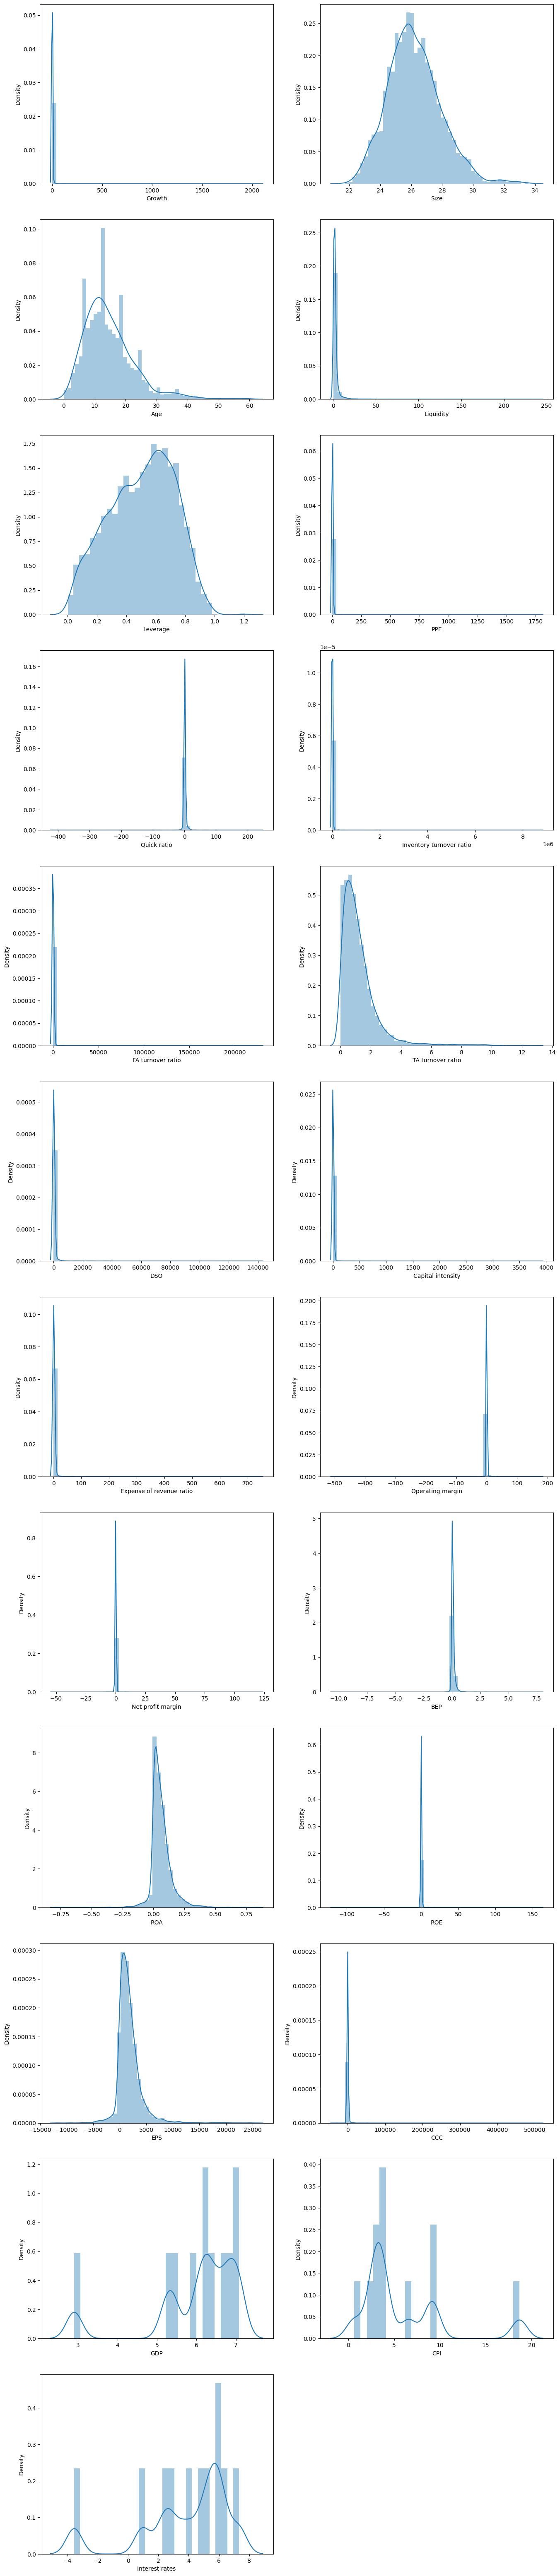

In [ ]:

plt.figure(figsize=(16,80))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(12,2,x)
    sns.distplot(data[i])
    x+=1
  plt.show()

density(['Growth', 'Size', 'Age', 'Liquidity', 'Leverage', 'PPE', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'TA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'BEP', 'ROA', 'ROE', 'EPS', 'CCC', 'GDP', 'CPI', 'Interest rates'])

Deal with outliers

In [ ]:
def highest_lowest(list_variables):
  for i in list_variables:
    print(f"Highest allowed of {i}",data[i].mean() + 3*data[i].std())
    print(f"Lowest allowed of {i}",data[i].mean() - 3*data[i].std())
    print('---------')

highest_lowest(['Growth', 'PPE', 'Liquidity', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'ROE', 'CCC'])

Highest allowed of Growth 87.35804716717814
Lowest allowed of Growth -85.71992184748285
---------
Highest allowed of PPE 82.04636374491608
Lowest allowed of PPE -79.35705977610664
---------
Highest allowed of Liquidity 19.737054006355358
Lowest allowed of Liquidity -14.748494586037724
---------
Highest allowed of Quick ratio 33.58606603505482
Lowest allowed of Quick ratio -31.298623503346455
---------
Highest allowed of Inventory turnover ratio 381933.4000469348
Lowest allowed of Inventory turnover ratio -375299.9022031872
---------
Highest allowed of FA turnover ratio 15679.06210473644
Lowest allowed of FA turnover ratio -15303.90603155602
---------
Highest allowed of DSO 12188.339931365648
Lowest allowed of DSO -11337.899978351095
---------
Highest allowed of Capital intensity 246.06203998924676
Lowest allowed of Capital intensity -234.30589881763873
---------
Highest allowed of Expense of revenue ratio 62.67924952519994
Lowest allowed of Expense of revenue ratio -58.50724376230078
-

In [ ]:
name = ['Growth', 'PPE', 'Liquidity', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'ROE', 'CCC']
def capping(df):
  upper_limit = df[name].mean() + 3*df[name].std()
  lower_limit = df[name].mean() - 3*df[name].std()
  for i in name:
    df[name] = np.where(
      df[name]>upper_limit,
      upper_limit,
      np.where(
          df[name]<lower_limit,
          lower_limit,
          df[name]
      )
  )

capping(data)
data.describe()

,Size,Leverage,Growth,PPE,Liquidity,Age,Quick ratio,Inventory turnover ratio,FA turnover ratio,TA turnover ratio,DSO,Capital intensity,Expense of revenue ratio,Operating margin,Net profit margin,ROA,ROE,EPS,BEP,CCC,GDP,CPI,Interest rates,Target
count,5349.000000,5500.000000,5422.000000,5478.000000,5500.000000,5671.000000,5447.000000,5632.000000,5493.000000,5488.000000,5493.000000,5488.000000,5493.000000,5493.000000,5389.000000,5401.000000,5401.000000,5424.000000,5500.000000,5632.000000,5676.000000,5676.000000,5676.000000,5676.000000
mean,26.206681,0.503325,0.394154,0.805668,2.322255,14.539058,1.322715,859.604250,60.869434,1.208536,270.502417,3.561490,1.431539,0.156534,0.076003,0.063025,0.216005,1751.246467,0.092343,381.484782,6.001623,5.821202,3.797918,0.625264
std,1.706232,0.220097,3.452518,3.953259,2.593976,8.030378,3.531191,15613.972332,550.442808,1.208844,1073.990343,16.194301,4.363704,1.286881,0.508483,0.081622,0.641309,2237.747674,0.252319,1876.425356,1.131059,4.809275,2.944192,0.484097
min,21.716518,0.001981,-0.997369,0.000000,0.097129,0.000000,-31.298624,0.002441,0.000916,0.000257,0.000000,0.078533,0.000000,-22.413873,-6.612608,-0.787392,-8.810799,-11820.461130,-10.587992,-25121.662701,2.905836,0.631201,-3.551709,0.000000
25%,25.040748,0.339080,-0.089543,0.069949,1.124654,9.000000,0.496845,2.473381,1.914813,0.464491,26.725062,0.640350,0.453810,0.023277,0.017170,0.015613,0.041223,515.256803,0.022247,50.453632,5.421883,2.795824,2.294892,0.000000
50%,26.061765,0.525305,0.071820,0.188784,1.505083,13.000000,0.898045,4.971114,6.022258,0.919167,63.735184,1.087942,0.773390,0.060170,0.046602,0.048124,0.112584,1367.377280,0.058002,114.445307,6.240303,3.539628,4.825874,1.000000
75%,27.231882,0.676313,0.239977,0.479205,2.410178,19.000000,1.564948,11.715217,17.069339,1.561646,158.891812,2.152895,1.170790,0.141389,0.110268,0.093865,0.216295,2485.573435,0.114819,225.237739,6.812246,9.094703,5.814896,1.000000
max,33.590443,1.208426,87.358047,82.046364,19.737054,60.000000,33.586066,381933.400047,15679.062105,12.733542,12188.339931,246.062040,62.679250,22.582316,6.759415,0.839056,9.302494,25717.077680,7.906537,26335.734538,7.075789,18.677732,7.322258,1.000000


Re-visualize values' distribution in each column.

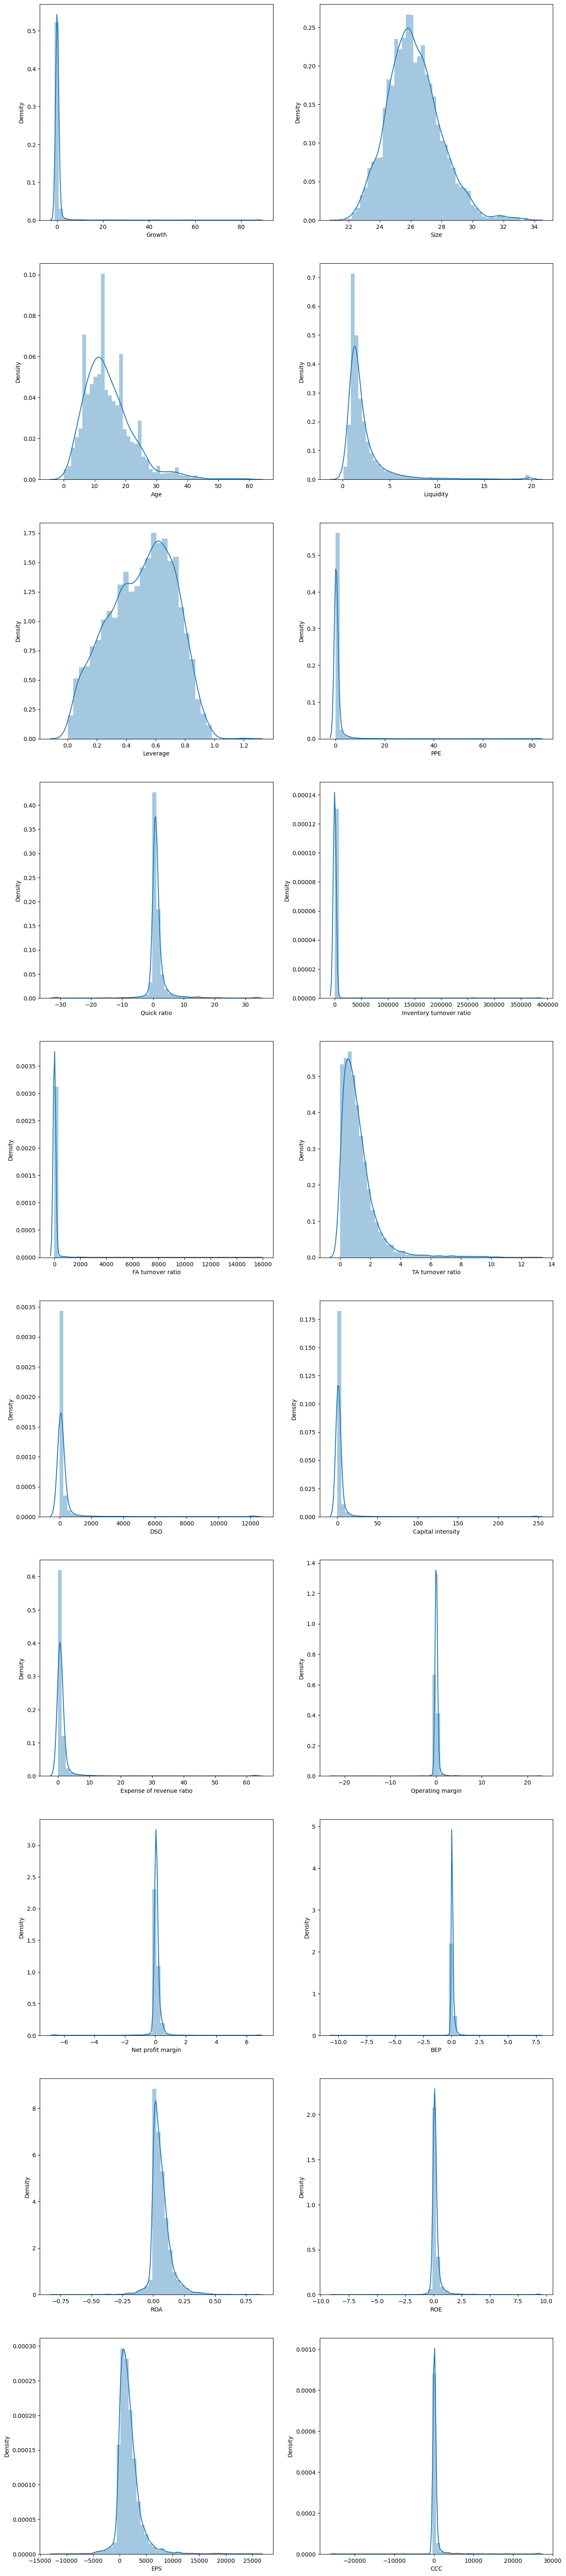

In [ ]:

plt.figure(figsize=(16,80))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(10,2,x)
    sns.distplot(data[i])
    x+=1
  plt.show()

density(['Growth', 'Size', 'Age', 'Liquidity', 'Leverage', 'PPE', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'TA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'BEP', 'ROA', 'ROE', 'EPS', 'CCC'])

Có vấn đề: Quick ratio (phải >=0), Operating margin (phải < 1), Net profit margin (phải < 1).

In [ ]:
# Check proportion of missing values in each column

(data.isnull().sum()/5676*100).sort_values(axis=0, ascending=False)

Size                        5.761099
Net profit margin           5.056378
ROE                         4.844961
ROA                         4.844961
Growth                      4.474982
EPS                         4.439746
Quick ratio                 4.034531
PPE                         3.488372
Capital intensity           3.312192
TA turnover ratio           3.312192
Operating margin            3.224101
Expense of revenue ratio    3.224101
DSO                         3.224101
FA turnover ratio           3.224101
Leverage                    3.100775
Liquidity                   3.100775
BEP                         3.100775
Inventory turnover ratio    0.775194
CCC                         0.775194
Age                         0.088090
GDP                         0.000000
CPI                         0.000000
Interest rates              0.000000
Target                      0.000000
dtype: float64

<Axes: >

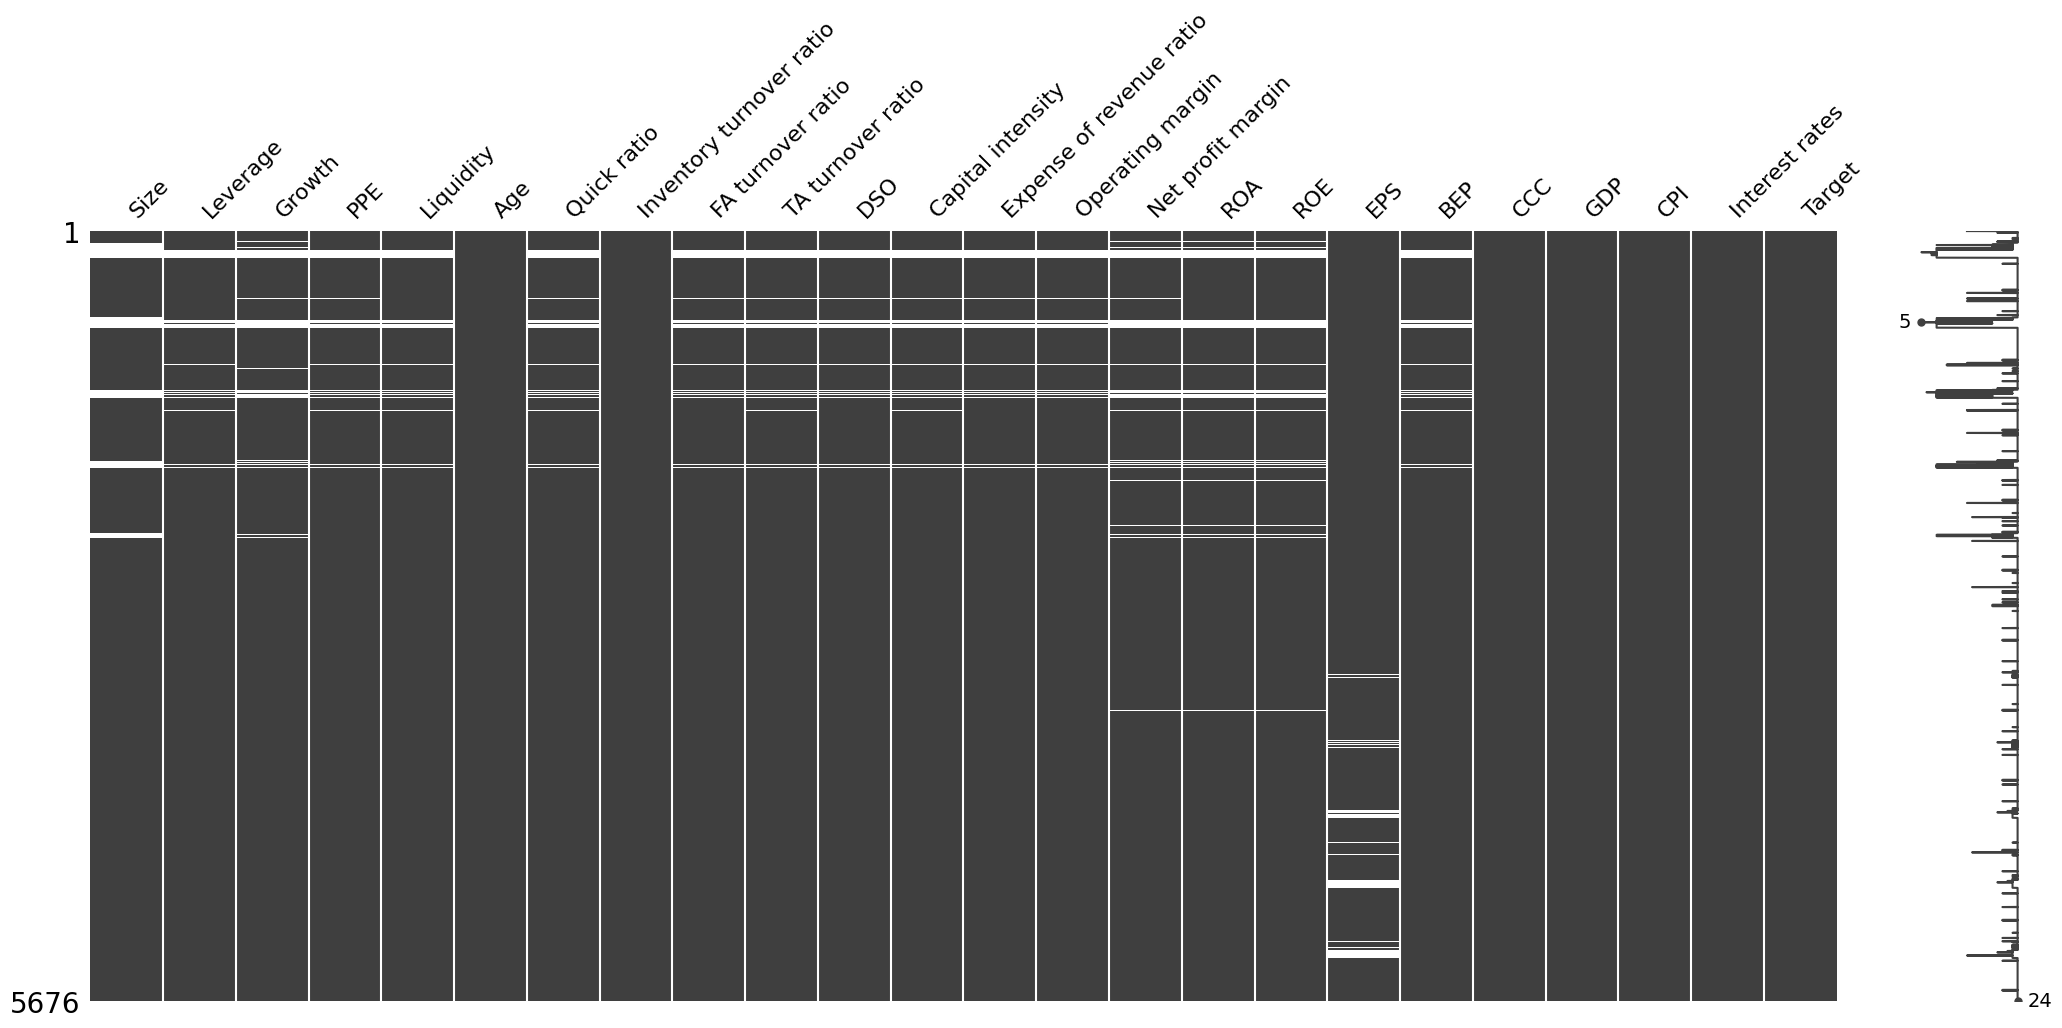

In [ ]:
import missingno

missingno.matrix(data)


In [ ]:
# Drop rows that have at least 1 NaN
new_data = data.dropna(axis=0)
new_data = new_data.astype({'Age': int})
print(new_data.shape)  # (5002, 24) --> Remains 5002 observations.

print(new_data.isnull().sum().sum()) # Clear all NaNs.

(5002, 24)
0


<Axes: >

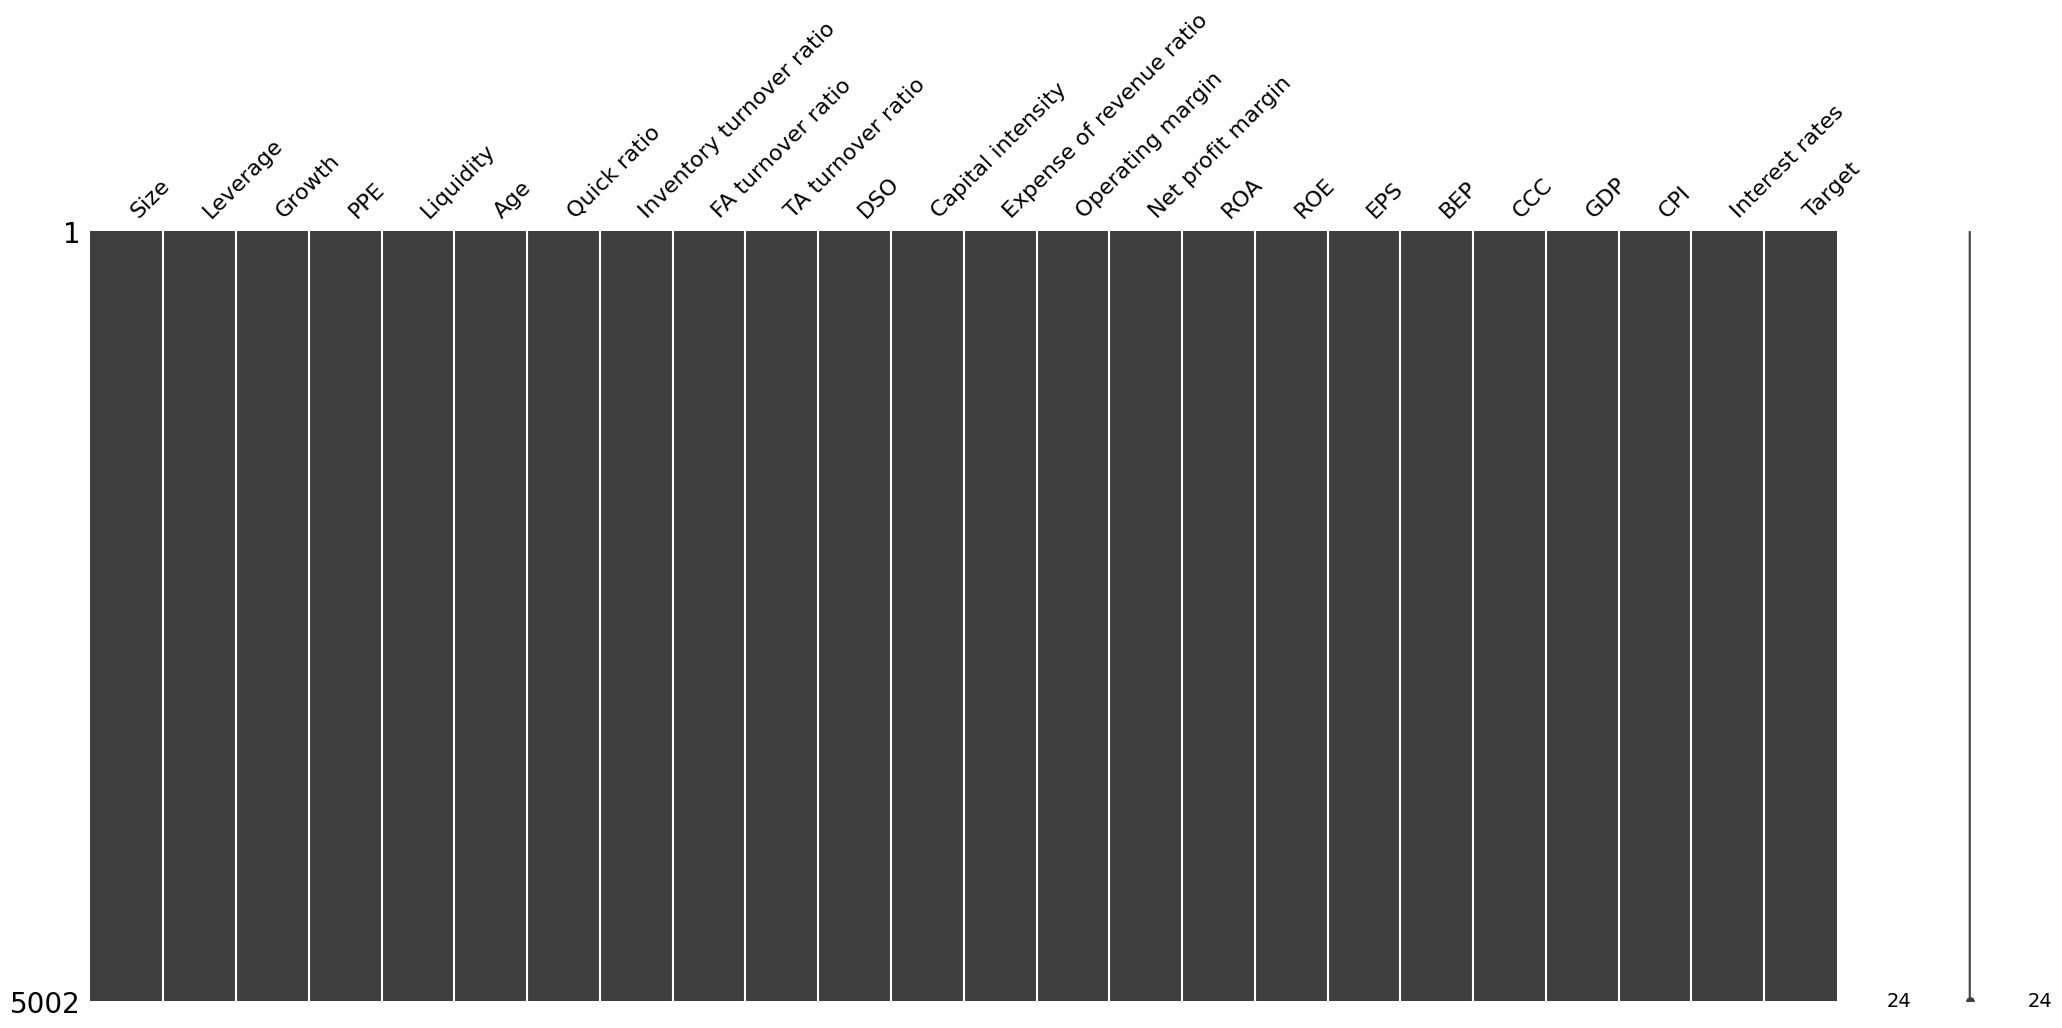

In [ ]:
import missingno

missingno.matrix(new_data)

#Test Neural Network Model

In [ ]:
from keras import feature_column
# Import required libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Preprocess the data
scaler = MinMaxScaler()
feature= ['Size', 'Leverage', 'Growth', 'PPE','Liquidity', 'ROE','ROA','EPS','Quick ratio','Capital intensity','TA turnover ratio',
          'Operating margin','Expense of revenue ratio','DSO','FA turnover ratio','BEP','Inventory turnover ratio','CCC','Age', 'GDP','CPI','Interest rates']
X = new_data[feature]
y = new_data["Target"]

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X.iloc[0:train_size], X.iloc[train_size:len(X)]
y_train, y_test = y.iloc[0:train_size], y.iloc[train_size:len(y)]

# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, input_dim=2, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Train the model
# model.fit(X_train, y_train, epochs=100, batch_size=32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#scale data
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)
clf=MLPClassifier(hidden_layer_sizes=[100,100], alpha=5, random_state=0, solver='lbfgs').fit(X_train_scaled,y_train)
print('Accuracy of NN classifier on training set: %.4f %%' % (100*clf.score(X_train_scaled, y_train)))
print('Accuracy of NN classifier on testing set: %.4f %%' % (100*clf.score(X_test_scaled, y_test)))



Accuracy of NN classifier on training set: 72.4364 %
Accuracy of NN classifier on testing set: 71.4191 %


In [ ]:
new_data

Size  Leverage    Growth       PPE  Liquidity  Age  \
Year Company                                                            
2010 POM.HM   29.308265  0.631919  0.485906  0.161338   1.399731   11   
     V21.HN   24.511991  0.909509  0.728948  0.044329   1.194372    5   
     LIG.HN   26.171438  0.810075  0.669013  0.281770   1.406351   14   
     MCC.HN   25.514182  0.071271  0.189628  0.244802   5.807324    4   
     TET.HN   25.898235  0.138308 -0.134951  1.277403   1.260596   40   
...                 ...       ...       ...       ...        ...  ...   
2020 DAG.HM   26.623564  0.610937  0.074296  0.402745   1.166272   19   
     PVL.HN   25.277143  0.410206  0.589727  1.957516   0.909948   13   
     CCI.HM   26.508283  0.602509 -0.244980  0.171636  11.352394   28   
     PPP.HN   25.322819  0.256210 -0.226251  0.588233   1.761310   20   
     IJC.HM   28.842630  0.688299  0.338464  0.440331   1.481065   13   

              Quick ratio  Inventory turnover ratio  FA turnover ratio  \
Year Company                                                             
2010 POM.HM      0.717048                  4.051764           2.270428   
     V21.HN      0.274740                  1.559963          19.697700   
     LIG.HN      0.945083                  3.843361           0.512498   
     MCC.HN      4.116953                  6.262846          10.374847   
     TET.HN      1.248604                432.969958           1.095194   
...                   ...                       ...                ...   
2020 DAG.HM      0.447435                  2.871849          15.073621   
     PVL.HN      0.874132                  3.989148           0.574304   
     CCI.HM     10.813581                 20.879260           3.837863   
     PPP.HN      1.307953                  8.275423           3.926553   
     IJC.HM      0.786886                  0.968705           3.538940   

              TA turnover ratio          DSO  Capital intensity  \
Year Company                                                      
2010 POM.HM            1.461675    97.303558           0.684146   
     V21.HN            1.132611    85.475842           0.882916   
     LIG.HN            0.895913   528.605058           1.116179   
     MCC.HN            0.733156    10.894706           1.363966   
     TET.HN            0.591485     7.582282           1.690661   
...                         ...          ...                ...   
2020 DAG.HM            1.009896    14.679956           0.990201   
     PVL.HN            0.058207  1056.801314          17.180152   
     CCI.HM            0.419079    14.687985           2.386182   
     PPP.HN            0.808258    17.741317           1.237228   
     IJC.HM            0.322399    47.796188           3.101750   

              Expense of revenue ratio  Operating margin  Net profit margin  \
Year Company                                                                  
2010 POM.HM                   1.052063          0.005026           0.066280   
     V21.HN                   0.658292          0.037879           0.023508   
     LIG.HN                   2.505594          0.162164           0.055030   
     MCC.HN                   1.694083          0.187835           0.238117   
     TET.HN                   0.262651          0.147891           0.197048   
...                                ...               ...                ...   
2020 DAG.HM                   0.091568          0.017150           0.005769   
     PVL.HN                   1.822281          0.764657           0.027878   
     CCI.HM                   0.489455          0.034389           0.103947   
     PPP.HN                   0.381667          0.010540           0.079802   
     IJC.HM                   0.033609          0.063179           0.161416   

                   ROA       ROE         EPS       BEP         CCC       GDP  \
Year Company                                                                   
2010 POM.HM   0.096879  0.212873 -1108.31199  

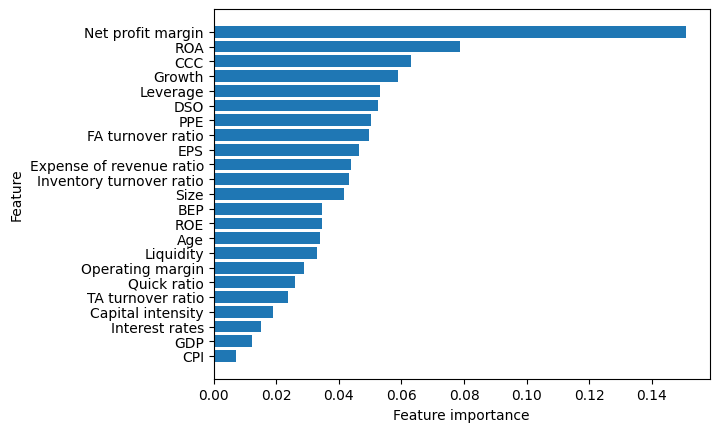

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

X = new_data.drop(['Target'], axis=1)
y = new_data['Target']


# Fit the decision tree classifier to the data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X, y)

# Get the feature importances from the classifier
importances = clf.feature_importances_

# Sort the features by their importance
sorted_indices = importances.argsort()

# Plot the feature importances
plt.barh(range(X.shape[1]), importances[sorted_indices])
plt.yticks(range(X.shape[1]), X.columns[sorted_indices])
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Get the feature importances from the classifier and create a dataframe
importances = clf.feature_importances_
df_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the dataframe by importance in ascending order
df_importances_sorted = df_importances.sort_values('Importance', ascending=False)

# Print the sorted dataframe
print(df_importances_sorted)

                     Feature  Importance
14         Net profit margin    0.150947
15                       ROA    0.078665
19                       CCC    0.062959
2                     Growth    0.058781
1                   Leverage    0.053003
10                       DSO    0.052414
3                        PPE    0.050388
8          FA turnover ratio    0.049542
17                       EPS    0.046312
12  Expense of revenue ratio    0.043818
7   Inventory turnover ratio    0.043114
0                       Size    0.041728
18                       BEP    0.034571
16                       ROE    0.034478
5                        Age    0.034065
4                  Liquidity    0.032983
13          Operating margin    0.028865
6                Quick ratio    0.026084
9          TA turnover ratio    0.023743
11         Capital intensity    0.018914
22            Interest rates    0.015244
20                       GDP    0.012376
21                       CPI    0.007005


In [ ]:
df_importances_sorted.to_csv('ft_importance.csv', index=False)

In [ ]:
# # List of features used to build models because feature_importance > 0.03.
# features = df_importances[df_importances['Importance'] > 0.03]['Feature'].tolist()
# # Add the target variable to the list of features
# features.append("Target")

# features

In [ ]:
# # Choose only cols have feature_importance > 0
# new_data = new_data[features]
# new_data

In [ ]:
# Define a function to replace outliers with 1st or 3rd quantile
def replace_outliers(new_data, q1=0.25, q3=0.75):
    """
    Replace outliers in a dataframe using the Interquartile Range (IQR) method.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing the data
    q1 : float
        The first quartile (default is 0.25)
    q3 : float
        The third quartile (default is 0.75)

    Returns:
    --------
    pandas.DataFrame
        Dataframe with outliers replaced with 1st or 3rd quantile
    """
    # Calculate the interquartile range (IQR) for each column
    q1_vals = new_data.quantile(q=q1)
    q3_vals = new_data.quantile(q=q3)
    iqr = q3_vals - q1_vals

    # Determine the upper and lower bounds for outliers
    lower_bound = (q1_vals - 1.5 * iqr)
    upper_bound = (q3_vals + 1.5 * iqr)

    # Replace outliers with the lower or upper bound
    for col in new_data.columns:
        new_data.loc[new_data[col] < lower_bound[col], col] = lower_bound[col]
        new_data.loc[new_data[col] > upper_bound[col], col] = upper_bound[col]

    return new_data

# Replace outliers using the IQR method
new_data = replace_outliers(new_data)


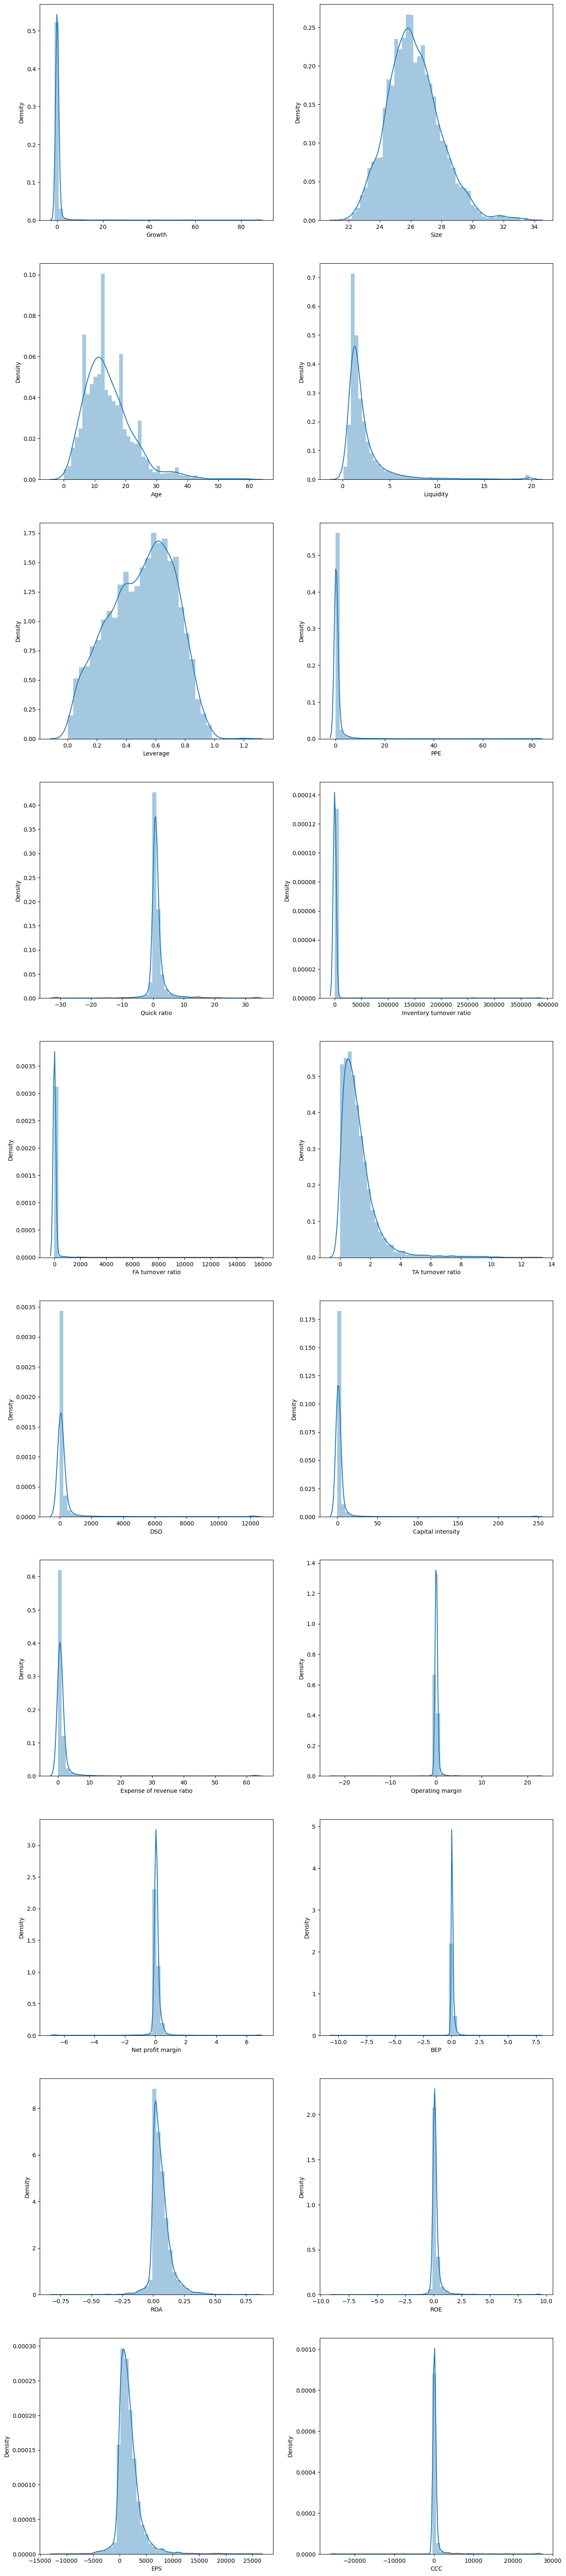

In [ ]:
plt.figure(figsize=(16,80))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(10,2,x)
    sns.distplot(data[i])
    x+=1
  plt.show()
# density(['Growth', 'Size', 'Age', 'Liquidity', 'Leverage', 'PPE', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'TA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'BEP', 'ROA', 'ROE', 'EPS', 'CCC', 'GDP', 'CPI', 'Interest rates'])
density(['Growth', 'Size', 'Age', 'Liquidity', 'Leverage', 'PPE', 'Quick ratio', 'Inventory turnover ratio', 'FA turnover ratio', 'TA turnover ratio', 'DSO', 'Capital intensity', 'Expense of revenue ratio', 'Operating margin', 'Net profit margin', 'BEP', 'ROA', 'ROE', 'EPS', 'CCC'])

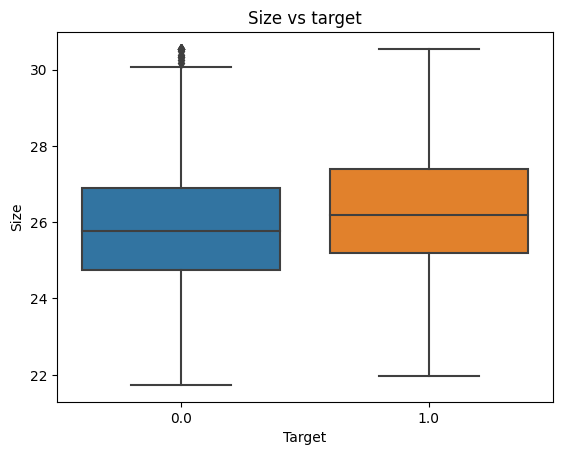

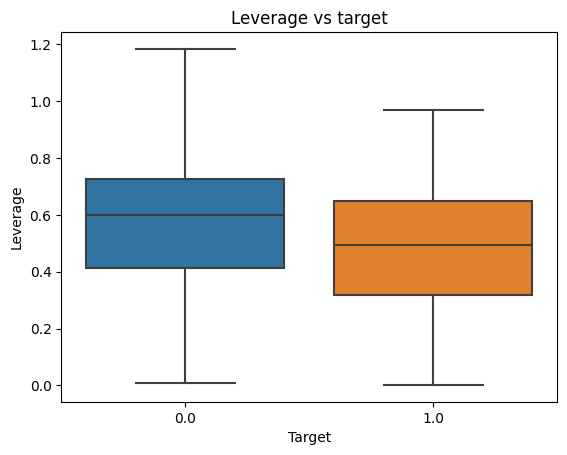

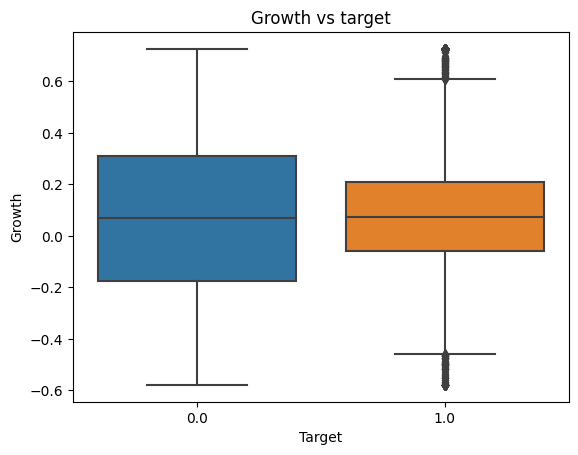

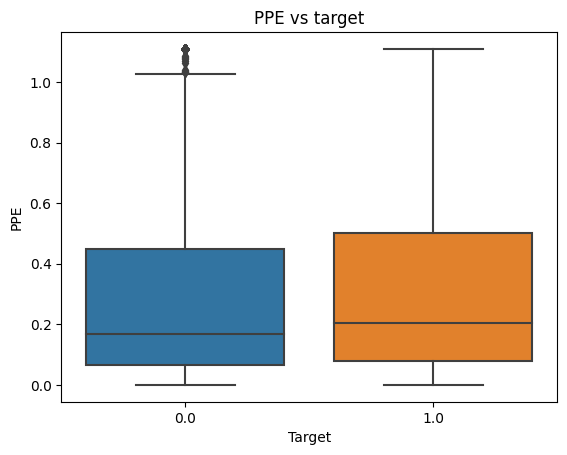

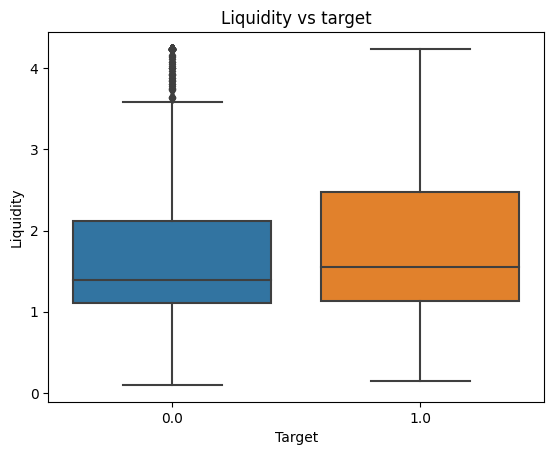

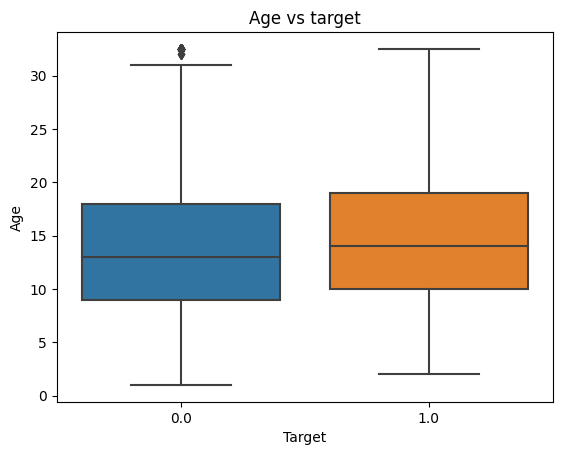

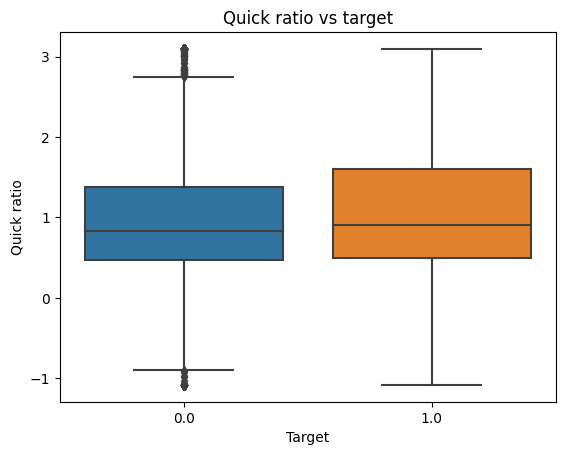

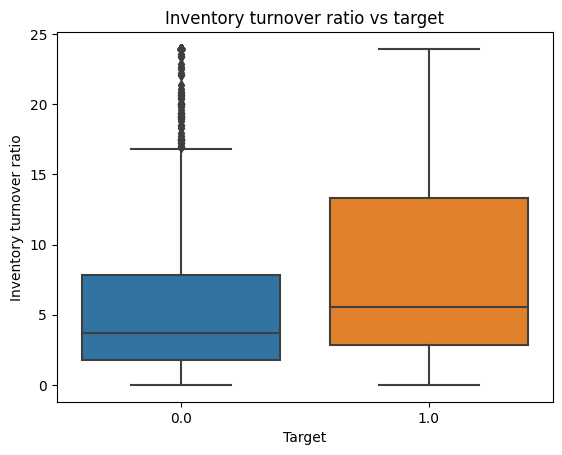

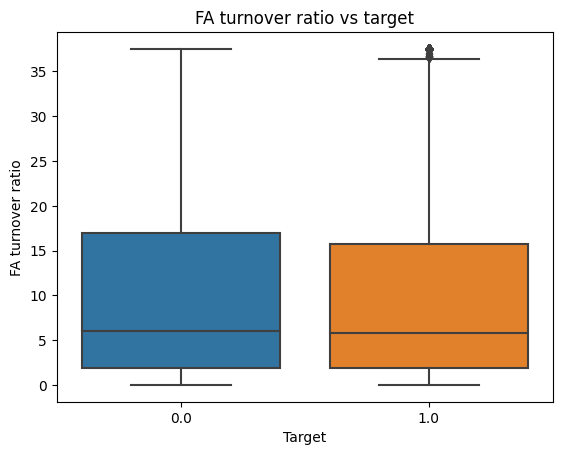

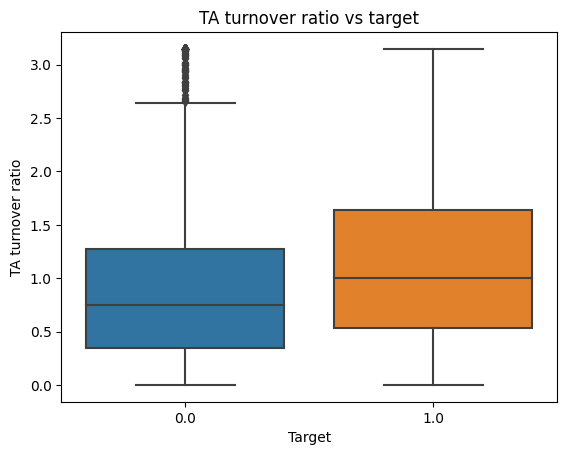

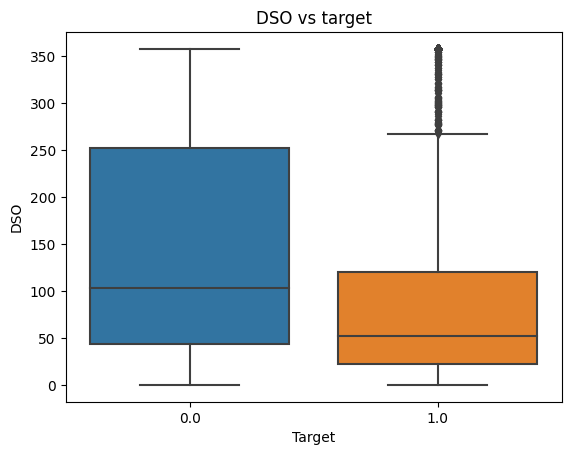

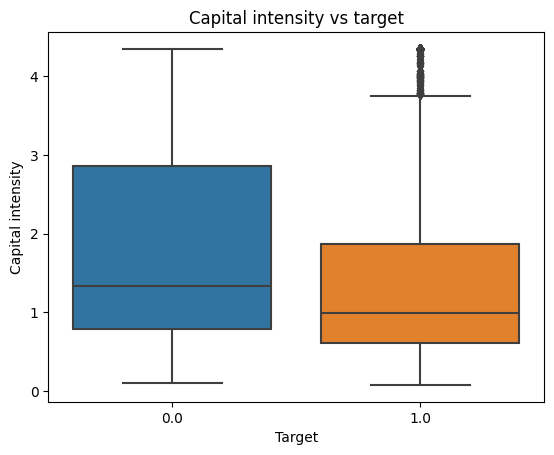

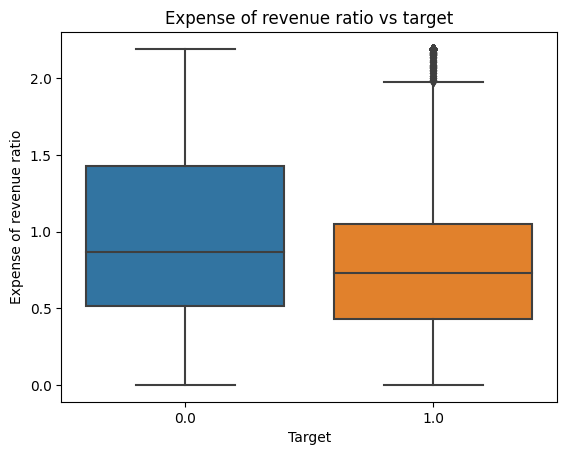

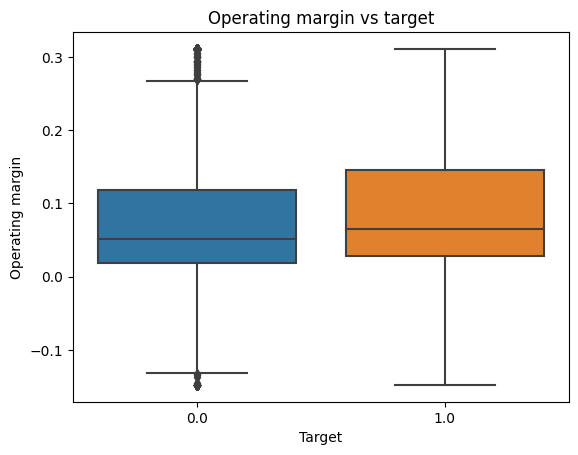

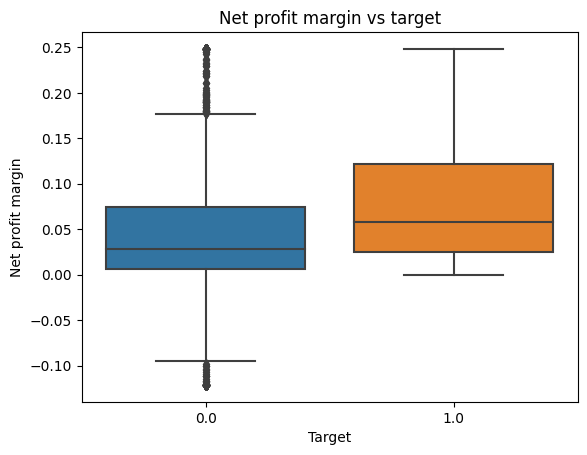

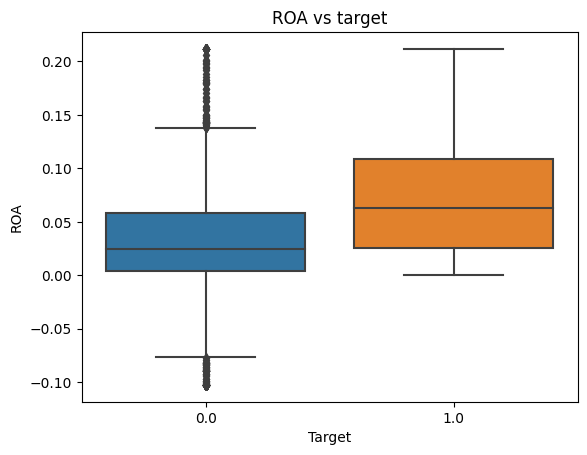

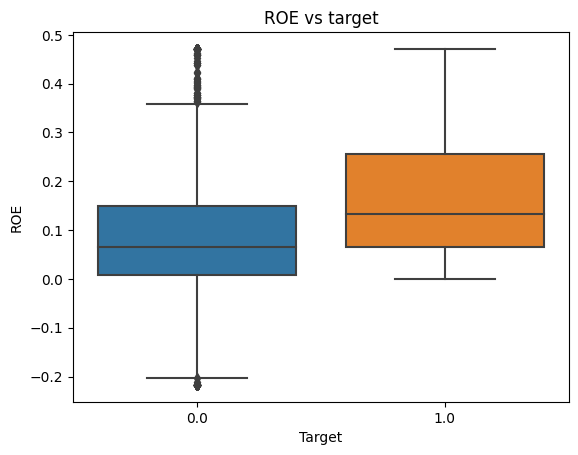

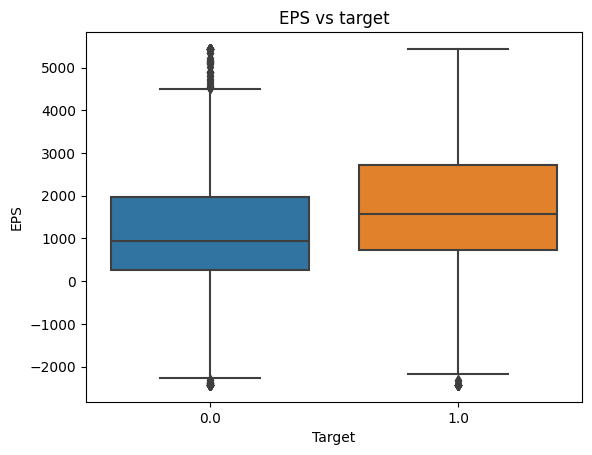

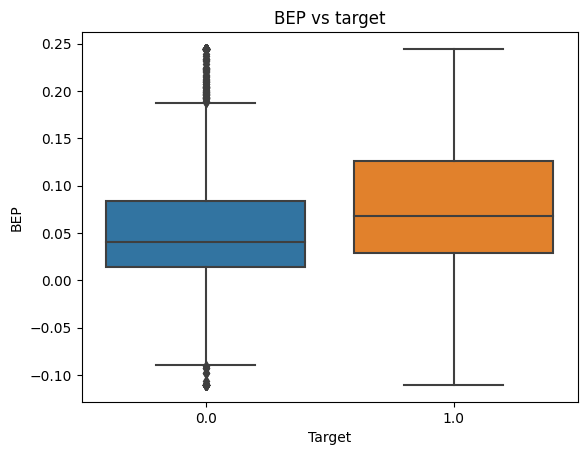

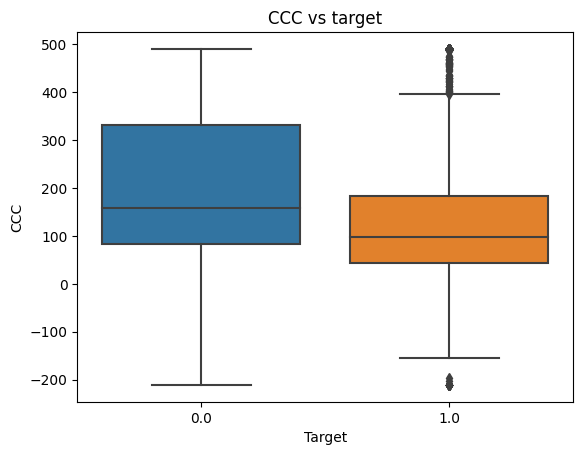

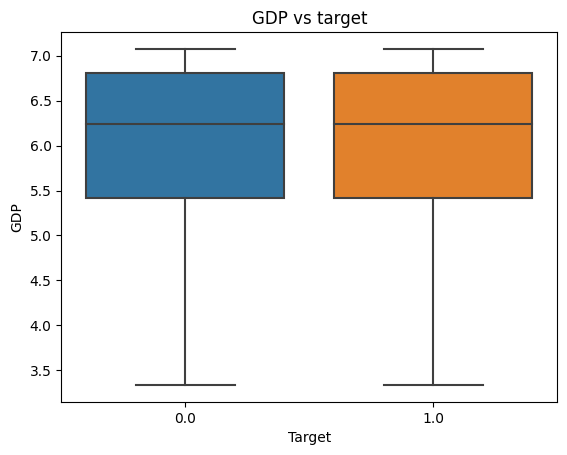

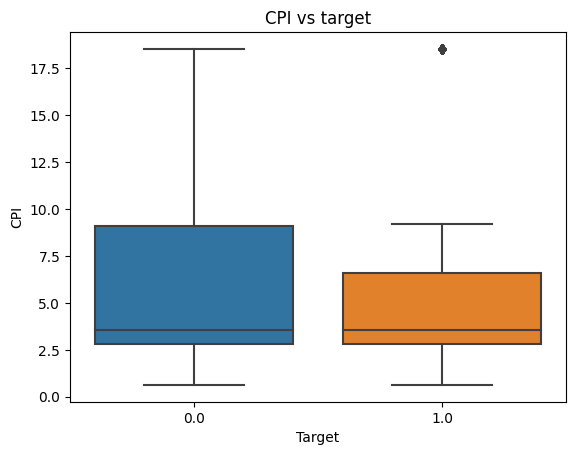

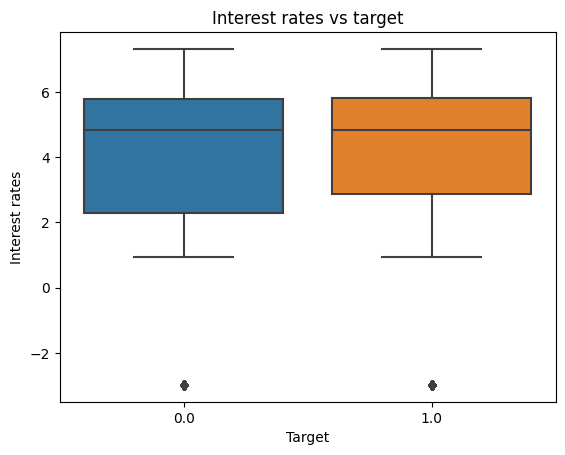

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot each variable against the target variable
for col in new_data.columns[:-1]:
    sns.boxplot(x='Target', y=col, data=new_data)
    plt.title(col + " vs target")
    plt.show()

**Build model**


Split train-test sets

In [ ]:

X = new_data.drop('Target', axis=1)
y = new_data.Target

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)

# Scale X
scaler = StandardScaler()
scaler.fit(X)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

#Check which algorithm is optimal for this prediction.

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Support Vector Machine (Linear Kernel)': LinearSVC(),
    'Support Vector Machine (RBF Kernel)': SVC(),
    'Neural Network': MLPClassifier(),
    'Random Forest': RandomForestClassifier(),
}

for name, model in models.items():
  model.fit(X_train, y_train)
  print(name + ' trained.')

Logistic Regression trained.
K-Nearest Neighbors trained.
Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
Support Vector Machine (RBF Kernel) trained.
Neural Network trained.
Random Forest trained.


In [ ]:
for name, model in models.items():
  result = model.score(X_test, y_test)
  print(name + ': {:.2f}%'.format(result * 100))

Logistic Regression: 71.63%
K-Nearest Neighbors: 68.93%
Decision Tree: 65.53%
Support Vector Machine (Linear Kernel): 72.33%
Support Vector Machine (RBF Kernel): 73.23%
Neural Network: 72.73%
Random Forest: 73.83%


--> The optimal is Random Forest.

#Build Model Random Forest

In [ ]:
def baseline_model(X_train, y_train, X_test, y_test):
    baseline = LogisticRegression(random_state=38)
    baseline.fit(X_train, y_train)

    # predict on test set
    y_pred_baseline = baseline.predict(X_test)

    # print evaluation metrics
    print("\nLogistic regression:")
    print(confusion_matrix(y_test, y_pred_baseline))
    print(classification_report(y_test, y_pred_baseline))

    # Create heatmap using seaborn
    sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, cmap="Blues", fmt="d",
                    xticklabels=["0", "1"],
                    yticklabels=["0", "1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # predict probabilities for test set
    y_pred_prob_baseline = baseline.predict_proba(X_test)[:, 1]

    # calculate ROC-AUC score
    roc_auc_baseline = roc_auc_score(y_test, y_pred_prob_baseline)

    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_baseline)
    plt.plot(fpr, tpr, label='Logistic Regression (AUC = {:.2f})'.format(roc_auc_baseline))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    return baseline


Logistic regression:
[[137 201]
 [ 83 580]]
              precision    recall  f1-score   support

         0.0       0.62      0.41      0.49       338
         1.0       0.74      0.87      0.80       663

    accuracy                           0.72      1001
   macro avg       0.68      0.64      0.65      1001
weighted avg       0.70      0.72      0.70      1001



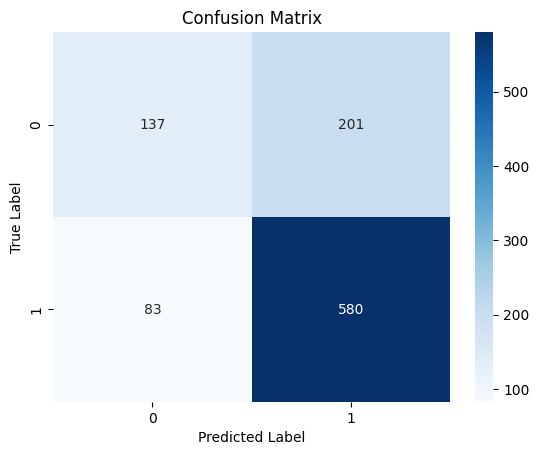

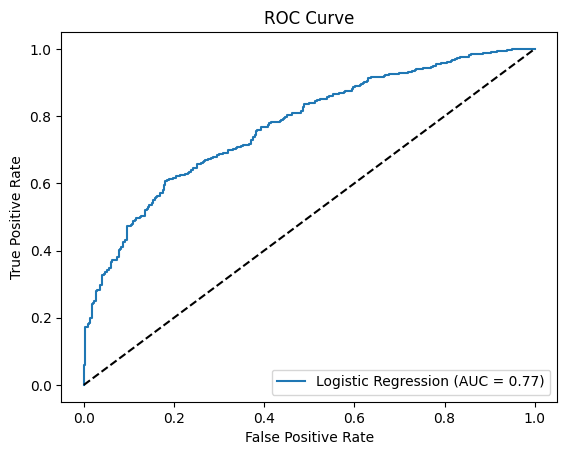

LogisticRegression(random_state=38)

In [ ]:
baseline_model(X_train, y_train, X_test, y_test)

In [ ]:
def random_forest_tuning(X_train, y_train, X_test, y_test):
# define parameter grid
    param_grid = {'n_estimators': [10],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 11),
    'min_samples_leaf': range(1, 6)}
    # create grid search object
    grid = GridSearchCV(RandomForestClassifier(random_state=38), param_grid, cv=5, scoring='accuracy')

    # fit grid search object to data
    grid.fit(X_train, y_train)

    # print results
    print("Best parameters: ", grid.best_params_)
    print("Best cross-validation score: {:.2f}".format(grid.best_score_))

    # use best parameters to fit model to data
    rf = grid.best_estimator_
    rf.fit(X_train, y_train)

    # predict on test set
    y_pred_rf = rf.predict(X_test)

    # print evaluation metrics
    print("\nRandom Forest:")
    print(confusion_matrix(y_test, y_pred_rf))
    print(classification_report(y_test, y_pred_rf))

    # Create heatmap using seaborn
    sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, cmap="Blues", fmt="d",
                xticklabels=["0", "1"],
                yticklabels=["0", "1"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    return rf

In [ ]:
from sklearn.decomposition import PCA

# instantiate PCA with n_components=10
pca = PCA(n_components=10)

# fit and transform the data
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# create a new dataframe with the transformed data
X_train_pca_df = pd.DataFrame(X_train_pca, columns=['PC1', 'PC2',"PC3","PC4","PC5",'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=['PC1', 'PC2',"PC3","PC4","PC5",'PC6', 'PC7', 'PC8', 'PC9', 'PC10'])


Best parameters:  {'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 10}
Best cross-validation score: 0.71

Random Forest:
[[109 229]
 [ 71 592]]
              precision    recall  f1-score   support

         0.0       0.61      0.32      0.42       338
         1.0       0.72      0.89      0.80       663

    accuracy                           0.70      1001
   macro avg       0.66      0.61      0.61      1001
weighted avg       0.68      0.70      0.67      1001



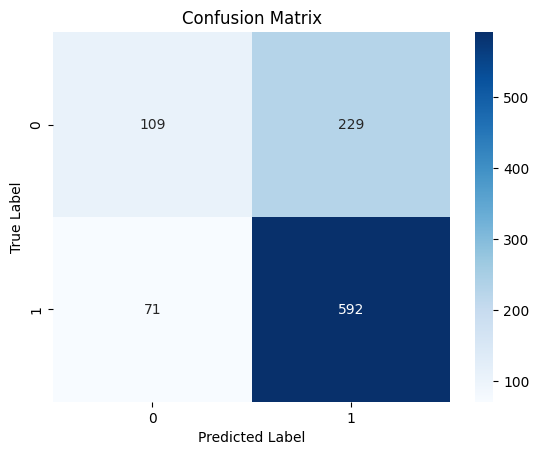

RandomForestClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=9,
                       n_estimators=10, random_state=38)

In [ ]:
import numpy as np
random_forest_tuning(X_train_pca_df, y_train, X_test_pca_df, y_test)

Best parameters:  {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
Best cross-validation score: 0.73

Random Forest:
[[131 207]
 [ 53 610]]
              precision    recall  f1-score   support

         0.0       0.71      0.39      0.50       338
         1.0       0.75      0.92      0.82       663

    accuracy                           0.74      1001
   macro avg       0.73      0.65      0.66      1001
weighted avg       0.73      0.74      0.72      1001



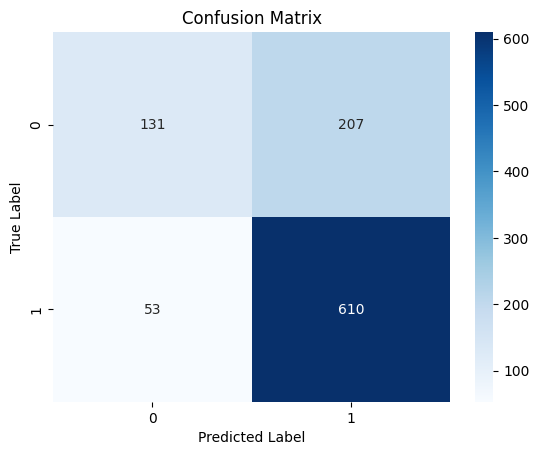

RandomForestClassifier(max_depth=9, n_estimators=10, random_state=38)

In [ ]:
import numpy as np
random_forest_tuning(X_train, y_train, X_test, y_test)

#Distribution of target column

In [ ]:
# For test set

y_test.value_counts() / len(y_test)

1.0    0.662338
0.0    0.337662
Name: Target, dtype: float64

In [ ]:
# For all of dataframe

y.value_counts() / len(y)

1.0    0.660936
0.0    0.339064
Name: Target, dtype: float64

**Build model using Random Forest**




optimal n_estimators value is 77 that accuracy is 0.7093174825174825


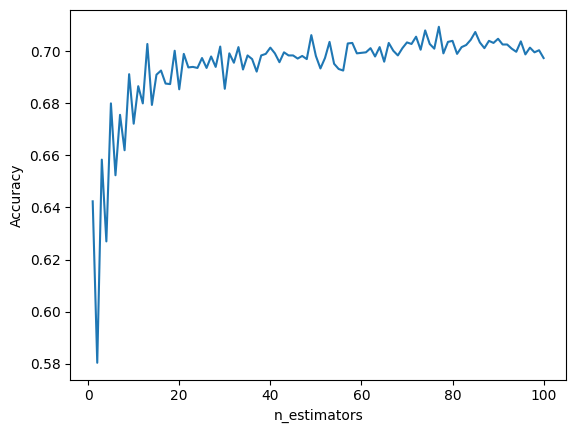

In [ ]:

n_estimators = list(range(1, 101))   # 100 trường hợp từ 1 đến 100 Decision Trees để tạo 100 Random Forest Metrics.
param_grid = {
    'n_estimators': n_estimators,
}
rf = RandomForestClassifier()
gs = GridSearchCV(rf, param_grid, cv=5)
gs.fit(X, y)
scores = gs.cv_results_['mean_test_score']

ind = np.where(scores == np.amax(scores))[0][0]+1

print(f'optimal n_estimators value is {ind} that accuracy is {scores.max()}')

import matplotlib.pyplot as plt
plt.plot(n_estimators, scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
rf = RandomForestClassifier(n_estimators=ind, random_state=10)

**ROC chart**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=0)

# Scale X
scaler = StandardScaler()
scaler.fit(X)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [ ]:

def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = rf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

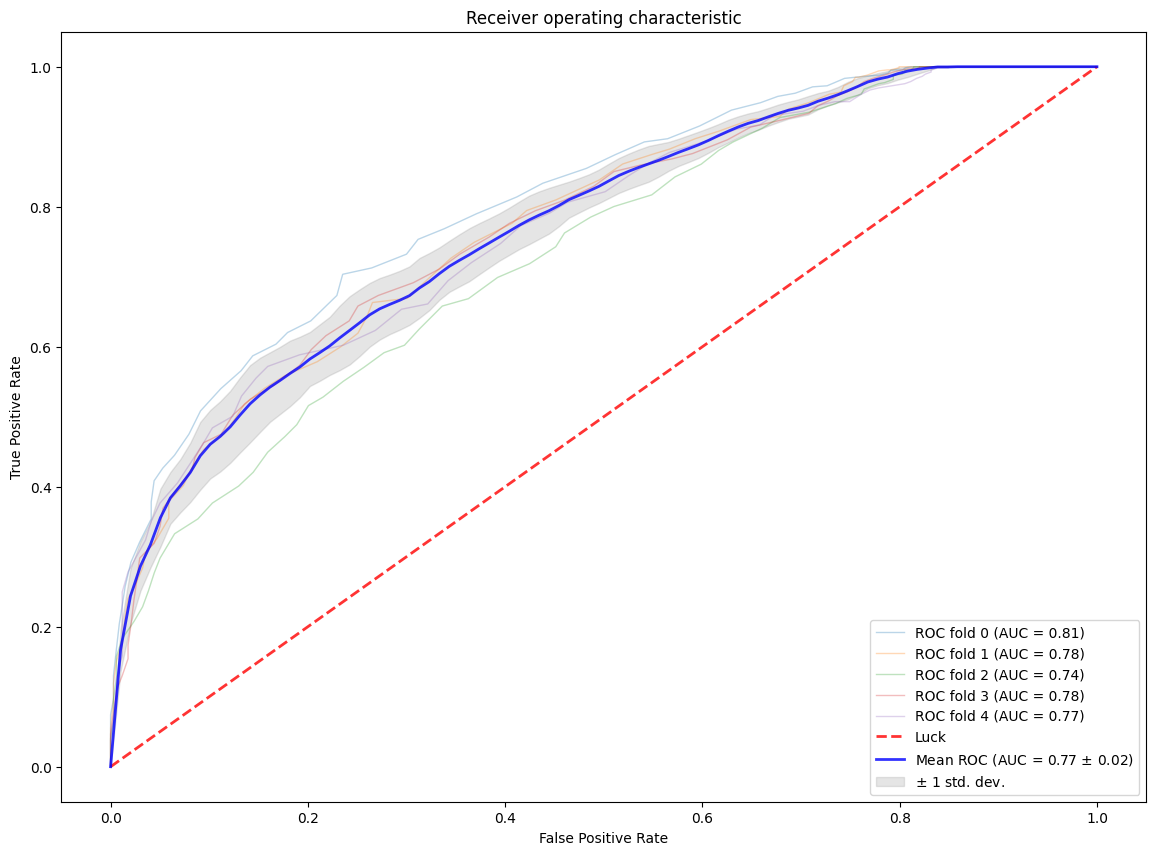

,AUC Train,AUC Test
0,1.0,0.809297
1,1.0,0.778349
2,1.0,0.736403
3,1.0,0.776492
4,1.0,0.772902


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    rf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

In [ ]:
from sklearn.metrics import roc_auc_score

# y_true: true binary labels, y_score: predicted scores
# of the positive class (can be probabilities or decision function scores)
auc_roc = roc_auc_score(y_train, y_test)
print("AUC-ROC score: ", auc_roc)

**Feature importance**

In [ ]:
ft_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(ft_imp)

**Correlation matrix**

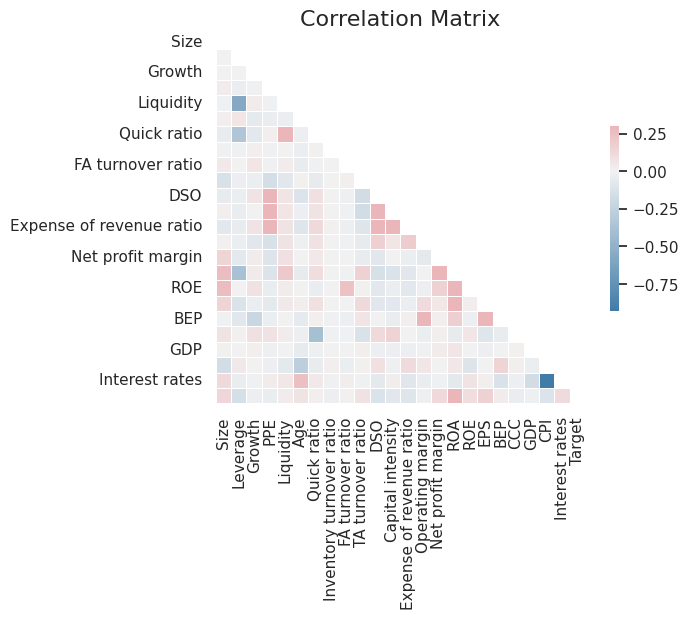

In [ ]:
def plot_correlation_matrix(corr_mat):
 sns.set(style="white")
 mask = np.zeros_like(corr_mat, dtype=np.bool)
 mask[np.triu_indices_from(mask)] = True
 fig, ax = plt.subplots()
 cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
 sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.3, center=0,
 square=True, linewidths=.5,
 cbar_kws={"shrink": .5}, ax=ax)
 ax.set_title('Correlation Matrix', fontsize=16)
 sns.set(style="darkgrid")
corr_mat = data.select_dtypes(include='number').corr()
plot_correlation_matrix(corr_mat)

**Confusion matrix**

In [ ]:
y_pred = rf.predict(X_test)

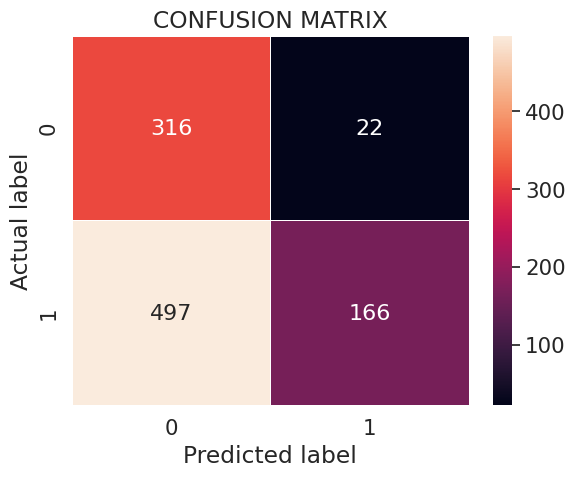

In [ ]:
import numpy as np
LABELS = [0, 1]
confusion_matrix = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix,
            annot=True,
            annot_kws={"size": 16},
            linewidths=.5, xticklabels=LABELS,
            yticklabels=LABELS, fmt='g') # font size
plt.title('CONFUSION MATRIX')
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
plt.show()

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

         0.0       0.39      0.93      0.55       338
         1.0       0.88      0.25      0.39       663

    accuracy                           0.48      1001
   macro avg       0.64      0.59      0.47      1001
weighted avg       0.72      0.48      0.44      1001



**Classification report**

The main score at 0.0 target is **recall**. As it appropriates when minimizing false loss is the focus.

The one at 1.0 target is **precision**. Because it appropriates when minimizing false profit is the focus.

In [ ]:
y_pred1 = rf.predict(X_train)

In [ ]:
report1 = classification_report(y_train, y_pred1)
print(report1)

              precision    recall  f1-score   support

         0.0       0.38      0.91      0.54      1358
         1.0       0.83      0.24      0.37      2643

    accuracy                           0.47      4001
   macro avg       0.61      0.57      0.45      4001
weighted avg       0.68      0.47      0.43      4001

